In [72]:
!pip install plotly geopy


[notice] A new release of pip is available: 25.0.1 -> 25.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [73]:
!pip install cartopy geopy


[notice] A new release of pip is available: 25.0.1 -> 25.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [74]:
!pip install folium


[notice] A new release of pip is available: 25.0.1 -> 25.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [75]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut
import folium
import numpy as np

In [76]:
# Initialize geolocator for country detection
geolocator = Nominatim(user_agent="flight_route_analyzer")

In [77]:
# Function to get country from city
def get_country(city):
    try:
        location = geolocator.geocode(city, timeout=10)
        if location:
            address = location.raw.get('address', {})
            return address.get('country', 'Unknown')
        return 'Unknown'
    except GeocoderTimedOut:
        return 'Unknown'

In [78]:
# URL of the Wikipedia page
url = "https://en.wikipedia.org/wiki/List_of_busiest_passenger_flight_routes"

# Send a GET request to fetch the page
response = requests.get(url)
soup = BeautifulSoup(response.content, "html.parser")

In [79]:
# Initialize a list to store the flight data
flights = []

In [80]:
def clean_passengers(passenger_text):
    cleaned = re.sub(r'\[\d+\]', '', passenger_text).replace(',', '').strip()
    try:
        return int(cleaned)
    except ValueError:
        return None

In [81]:
# Function to extract year from table context
def get_table_year(table):
    caption = table.find_previous(["h2", "h3"])
    if caption:
        match = re.search(r'\b(20\d{2})\b', caption.text)
        if match:
            return match.group(1)
    caption = table.find("caption")
    if caption:
        match = re.search(r'\b(20\d{2})\b', caption.text)
        if match:
            return match.group(1)
    return None

In [82]:
# Find all tables with class 'wikitable'
tables = soup.find_all("table", class_="wikitable")

In [ ]:
# Function to get country and coordinates from city
def get_location(city):
    try:
        location = geolocator.geocode(city, timeout=10)
        if location:
            address = location.raw.get('address', {})
            country = address.get('country', 'Unknown')
            return country, location.latitude, location.longitude
        return 'Unknown', None, None
    except GeocoderTimedOut:
        return 'Unknown', None, None

# Process each table
for table in tables:
    # Determine route type based on table context
    caption = table.find_previous(["h2", "h3"])
    route_type = "International"  # Default
    if caption and "Domestic" in caption.text:
        route_type = "Domestic"
    
    # Get table year
    table_year = get_table_year(table)
    
    # Get headers to identify column indices
    headers = table.find("tr").find_all(["th", "td"])
    col_indices = {
        "from": None,
        "to": None,
        "passengers": None,
        "year": None
    }
    
    # Identify relevant columns
    for i, header in enumerate(headers):
        header_text = header.text.strip().lower()
        if "airport" in header_text or "city" in header_text:
            if col_indices["from"] is None:
                col_indices["from"] = i
            else:
                col_indices["to"] = i
        elif "passenger" in header_text:
            col_indices["passengers"] = i
        elif "year" in header_text:
            col_indices["year"] = i
    
    # Get all rows in the table body
    rows = table.find("tbody").find_all("tr")[1:]  # Skip header row
    
    for row in rows:
        cols = row.find_all("td")
        if len(cols) >= 3:  # Ensure enough columns
            # Extract data
            from_city = cols[col_indices["from"]].text.strip() if col_indices["from"] is not None else None
            to_city = cols[col_indices["to"]].text.strip() if col_indices["to"] is not None else None
            passengers = clean_passengers(cols[col_indices["passengers"]].text.strip()) if col_indices["passengers"] is not None else None
            year = cols[col_indices["year"]].text.strip() if col_indices["year"] is not None else table_year
            
            # Skip rows with missing critical data
            if from_city and to_city and passengers and year:
                # Clean city names (remove airport codes, extra info, state codes)
                from_city = re.sub(r'\([^)]*\)|\b[A-Z]{3}\b|\b[A-Z]{2}\b', '', from_city).strip()
                to_city = re.sub(r'\([^)]*\)|\b[A-Z]{3}\b|\b[A-Z]{2}\b', '', to_city).strip()
                
                # Get country and coordinates
                from_country, from_lat, from_lon = get_location(from_city)
                to_country, to_lat, to_lon = get_location(to_city)
                
                # Correct route type based on countries
                if from_country == to_country and from_country != 'Unknown':
                    route_type_corrected = "Domestic"
                else:
                    route_type_corrected = "International"
                
                # Only append if coordinates are available
                if from_lat and from_lon and to_lat and to_lon:
                    flights.append({
                        "From": from_city,
                        "To": to_city,
                        "Type": route_type_corrected,
                        "Year": year,
                        "Passengers": passengers,
                        "From_Country": from_country,
                        "To_Country": to_country,
                        "From_Lat": from_lat,
                        "From_Lon": from_lon,
                        "To_Lat": to_lat,
                        "To_Lon": to_lon
                    })

In [ ]:
# Create a DataFrame
df = pd.DataFrame(flights)
df

,From,To,Type,Year,Passengers,From_Country,To_Country,From_Lat,From_Lon,To_Lat,To_Lon
0,London,Dublin,International,2011,5106040,Unknown,Unknown,51.489334,-0.144055,53.349379,-6.260559
1,Moscow,Saint Petersburg,International,2011,5051518,Unknown,Unknown,55.625578,37.606392,59.960674,30.158655
2,London,Amsterdam,International,2011,4920551,Unknown,Unknown,51.489334,-0.144055,52.373080,4.892453
3,London,New York,International,2011,4869777,Unknown,Unknown,51.489334,-0.144055,40.712728,-74.006015
4,London,Dubai,International,2011,3630407,Unknown,Unknown,51.489334,-0.144055,25.074282,55.188539
...,...,...,...,...,...,...,...,...,...,...,...
95,"Atlanta,","Chicago,",International,2014,2720000,Unknown,Unknown,33.748992,-84.390264,41.875562,-87.624421
96,"Chicago,","Minneapolis,",International,2014,2720000,Unknown,Unknown,41.875562,-87.624421,44.977300,-93.265469
97,"Atlanta,","New York,",International,2014,2600000,Unknown,Unknown,33.748992,-84.390264,40.712728,-74.006015
98,"Atlanta,","Orlando,",International,2014,2620000,Unknown,Unknown,33.748992,-84.390264,28.542111,-81.379030


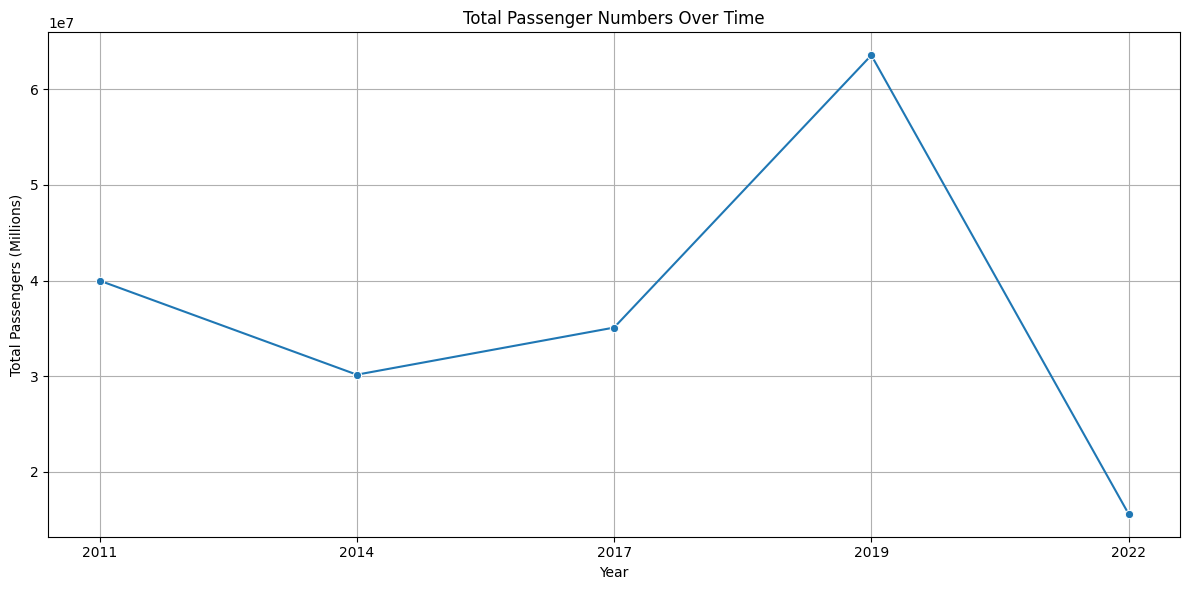

In [ ]:
# Visualization 1: Passenger Numbers Over Time
plt.figure(figsize=(12, 6))
passengers_by_year = df.groupby("Year")["Passengers"].sum().reset_index()
sns.lineplot(x="Year", y="Passengers", data=passengers_by_year, marker="o")
plt.title("Total Passenger Numbers Over Time")
plt.xlabel("Year")
plt.ylabel("Total Passengers (Millions)")
plt.grid(True)
plt.tight_layout()
plt.show()

C:\Users\Dell\AppData\Local\Temp\ipykernel_17084\604003978.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Passengers", y="Route", data=top_routes, palette="Blues_d")


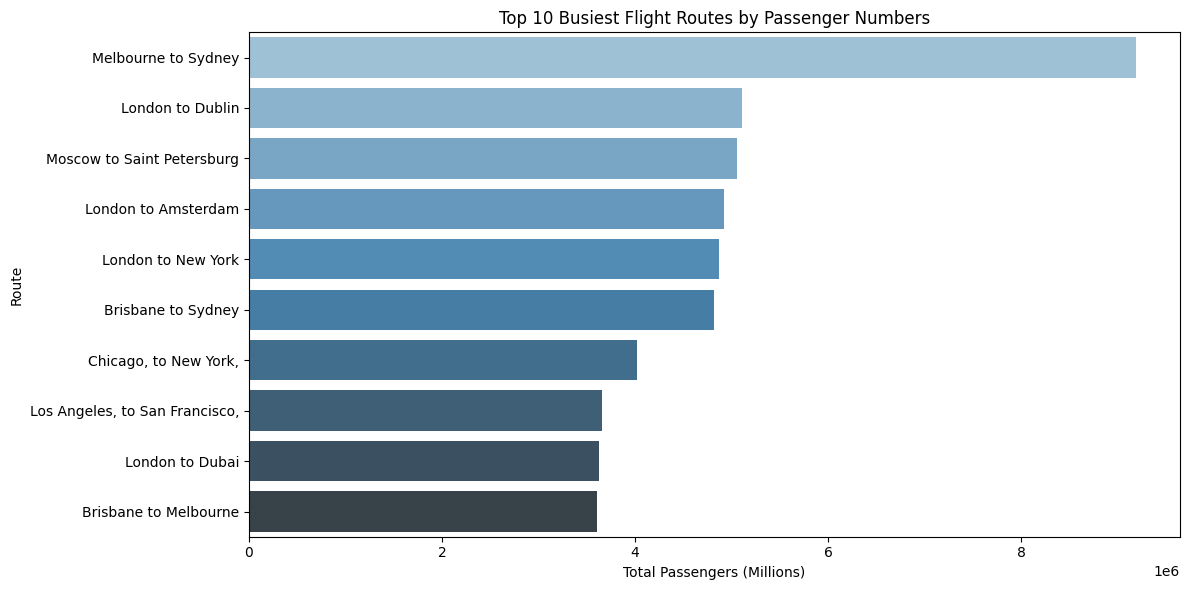

In [ ]:
# Visualization 2: Top 10 Busiest Routes
df["Route"] = df["From"] + " to " + df["To"]
top_routes = df.groupby("Route")["Passengers"].sum().reset_index().sort_values("Passengers", ascending=False).head(10)
plt.figure(figsize=(12, 6))
sns.barplot(x="Passengers", y="Route", data=top_routes, palette="Blues_d")
plt.title("Top 10 Busiest Flight Routes by Passenger Numbers")
plt.xlabel("Total Passengers (Millions)")
plt.ylabel("Route")
plt.tight_layout()
plt.show()

In [ ]:
df["From_Country"].unique

<bound method Series.unique of 0     Unknown
1     Unknown
2     Unknown
3     Unknown
4     Unknown
       ...   
95    Unknown
96    Unknown
97    Unknown
98    Unknown
99    Unknown
Name: From_Country, Length: 100, dtype: object>

In [ ]:
# Aggregate data to get total passengers per route
df["Route"] = df["From"] + " to " + df["To"]
route_data = df.groupby(["Route", "From", "To", "From_Lat", "From_Lon", "To_Lat", "To_Lon"])["Passengers"].sum().reset_index()

# Select top 10 busiest routes for visualization
top_routes = route_data.sort_values("Passengers", ascending=False).head(10)


In [ ]:
# Interactive Map with Folium
m = folium.Map(location=[20, 0], zoom_start=2, tiles="CartoDB positron")

for _, row in top_routes.iterrows():
    start = (row["From_Lat"], row["From_Lon"])
    end = (row["To_Lat"], row["To_Lon"])
    folium.CircleMarker(
        location=start,
        radius=5,
        color="green",
        fill=True,
        fill_color="green",
        popup=f"{row['From']}"
    ).add_to(m)
    folium.CircleMarker(
        location=end,
        radius=5,
        color="red",
        fill=True,
        fill_color="red",
        popup=f"{row['To']}"
    ).add_to(m)
    folium.PolyLine(
        locations=[start, end],
        color="gray",
        dash_array="5, 5",
        weight=2,
        popup=f"Route: {row['Route']}<br>Passengers: {row['Passengers']:,}"
    ).add_to(m)
    mid_lat = (row["From_Lat"] + row["To_Lat"]) / 2
    mid_lon = (row["From_Lon"] + row["To_Lon"]) / 2
    folium.Marker(
        location=[mid_lat, mid_lon],
        icon=folium.Icon(icon="plane", prefix="fa", color="blue"),
        popup=f"Midpoint of {row['Route']}"
    ).add_to(m)

# Save the map
m.save("interactive_flight_map.html")
print("Interactive map saved to 'interactive_flight_map.html'")

# Display in notebook
m

Interactive map saved to 'interactive_flight_map.html'
